In [1]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils

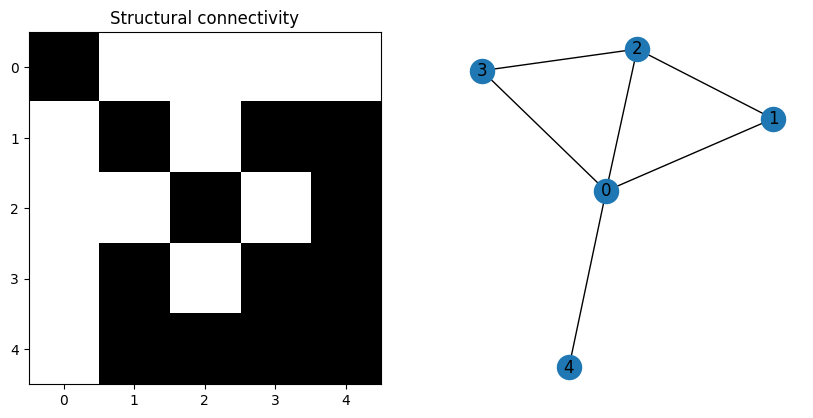

In [2]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_synthetic.pkl"

adj = utils.load(op.join(path_to_data, filename))
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

### Example of a forward pass

  0%|          | 0/20 [00:00<?, ?it/s]

Early stopping !


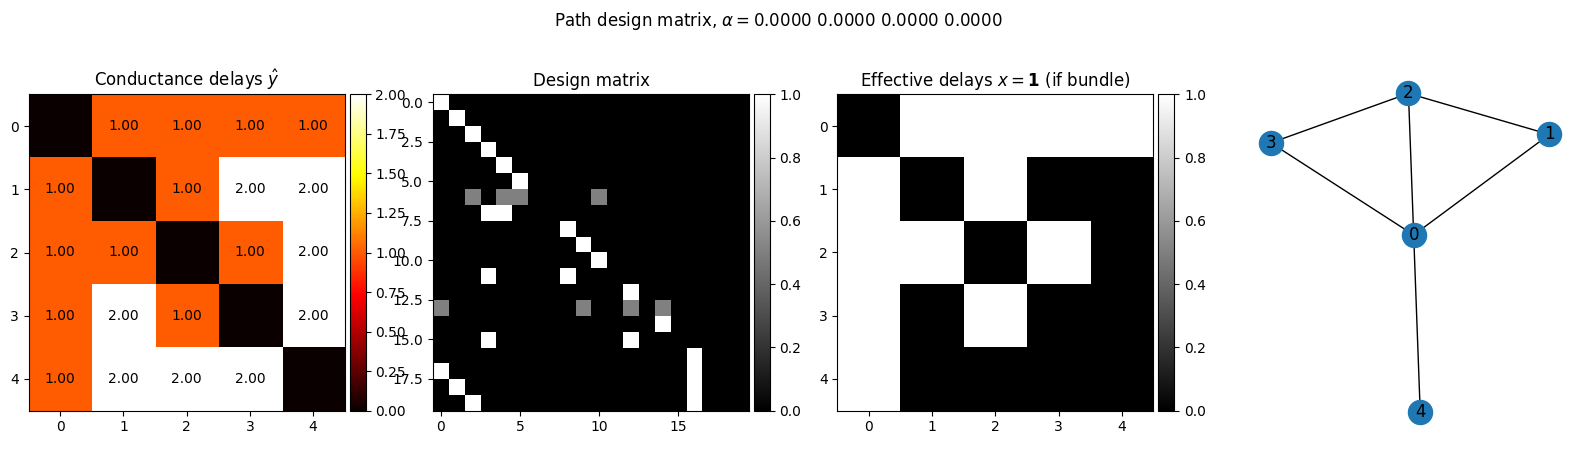

In [101]:
import importlib
importlib.reload(regmod)
importlib.reload(utils)

max_path_depth = 4

multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_model = design_shortest

y_pred_mat = regmod.predict_conduction_delays(design_model, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot')
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_model, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])


nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Backward pass: Jointly optimizing effective delays and alphas

In [29]:
def remove_diagonal_entries(A):
    return A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

def add_diagonal_entries(A):
    # add entries in diagonal position with zeros
    d = A.shape[0]
    assert A.shape[1] == d - 1
    ret = np.ndarray((d, d+1), dtype=A.dtype)
    ret[:,0] = 0
    ret[:-1,1:] = A.reshape((d-1, d))
    ret = ret.reshape(-1)[:-d].reshape(d,d)
    return ret

assert np.any(y_pred_mat == add_diagonal_entries(remove_diagonal_entries(y_pred_mat).flatten().reshape(y_pred_mat.shape[0],y_pred_mat.shape[0]-1)))

In [109]:
import torch
def combine_paths_matrices_torch(matrices, alpha):
    """Create a design matrix for the path model by combining the design matrices of
    each path lengths.

    Parameters
    ----------
    matrices : np.ndarray
        individual design matrices for each path length
    alpha : Union[float, np.ndarray], optional
        hyperparameter to include the influence of sub-optimal paths (could be one
        single value or a value for length greater than the shortest path), by default 0

    Returns
    -------
    np.ndarray
        design matrix of the path model.

    Raises
    ------
    ValueError
        the `alpha` parameter should be a scalar or have the same length as the number
        of matrices.
    """

    design = torch.zeros_like(matrices[0])
    alpha_id_vector = torch.zeros(design.shape[-1], dtype=int)
    alpha_norm = torch.zeros_like(alpha_id_vector)

    # Compatiblity for the type of alpha
    if isinstance(alpha, (float, int)):
        alpha = torch.tensor([alpha] * len(matrices))

    if len(alpha) != len(matrices):
        raise ValueError(
            "The alpha parameter must be a scalar or have the same length as the number"
            f" of matrices ({len(alpha)} alphas for {len(matrices)} matrices)."
        )

    for m in matrices:
        # Find rows that have already been filled
        has_shortest_paths = torch.any(design, axis=1)

        # Update the alpha vector for paths that have already been filled
        alpha_vector = has_shortest_paths * alpha[alpha_id_vector] + ~has_shortest_paths
        alpha_id_vector += has_shortest_paths * torch.any(m, axis=1)

        # Update the design matrix
        design += torch.diag(alpha_vector).type(torch.float64) @ m

        # # Early stopping if all rows have been filled and alpha is zero
        # if np.any(design, axis=1).all() and np.isclose(alpha, 0).all():
        #     print("Early stopping !")
        #     return design

    # Normalize the design matrix by 1 plus the sum of existing alpha weights
    alpha_norm = torch.tensor([1 + alpha[:i].sum() for i in alpha_id_vector])
    design /= alpha_norm
    return design


def forward(a_design, x):
    # Forward Pass for the path model
    y_pred = a_design @ x
    return y_pred

In [110]:
max_path_depth = 4
multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

  0%|          | 0/20 [00:00<?, ?it/s]

In [111]:
importlib.reload(regmod)
importlib.reload(utils)

x_opt = remove_diagonal_entries(adj).flatten()

a = .1
# Computes the alpha vector as alpha_n = a^n
alpha = torch.tensor([a**(i+1) for i in range(max_path_depth)])

design_model = combine_paths_matrices_torch(torch.tensor(multi_hops_design), alpha=alpha)
y_pred_mat = forward(design_model, torch.tensor(x_opt))

In [112]:
from copy import deepcopy
np.random.seed(99)
y_ground = deepcopy(y_pred_mat)
x_init = torch.tensor(np.random.rand(len(x_opt))).requires_grad_(True)
alphas_init = torch.tensor(np.random.rand(len(alpha))).requires_grad_(True)

In [122]:
def gradient_descent(x, y_ground, alphas, hops_design, step_size=1e-3, n_iter=1000, verbose=False):
    """
    Gradient descent for joint optimization of effective delay and alpha models
    """
    # evaluating with Mean Square Error (MSE)
    def criterion(y_est, y_ground):
        data_fit = torch.linalg.norm(y_est - y_ground)
        # TODO: Add perhaps some regularization on sparsity
        return data_fit

    for i in range(n_iter):
        a_design_model = combine_paths_matrices_torch(torch.tensor(hops_design), alpha=alphas)
        y_est = forward(a_design_model, x)

        loss = criterion(y_est, y_ground)
        loss.backward()

        # updateing the parameters after each iteration
        x.data = x.data - step_size * x.grad.data
        # alphas.data = alphas.data - step_size * alphas.grad.data

        # zeroing gradients after each iteration
        x.grad.data.zero_()
        # alphas.grad.data.zero_()

        # priting the values for understanding
        if verbose:
            if (i % (n_iter // 10)) == 0:
                print("{}, \t{}".format(i, loss.item()))

    return x.detach().numpy()

In [124]:
x_opt = gradient_descent(x_init, y_ground, 0, multi_hops_design, verbose=True)

0, 	0.21046818692976463
100, 	0.21035422145733434
200, 	0.21031052942990416
300, 	0.2102937472160878
400, 	0.21028729283675637
500, 	0.21028480844220512
600, 	0.21028385165915392
700, 	0.21028348306637223
800, 	0.21028334104082338
900, 	0.21028328630911697


In [125]:
x_opt

array([1.1001427 , 1.09818409, 1.10014253, 1.08213971, 1.10016876,
       1.06351676, 0.2976225 , 0.04669572, 1.09821033, 1.06348309,
       1.06353568, 0.7467671 , 1.10016893, 0.49414745, 1.06356853,
       0.39545404, 1.08216594, 0.52441472, 0.09361309, 0.81330841])